# Session 05 - Policy Gradients - Assignment

In this assignment you will implement REINFORCE, a policy gradient method based on Monte Carlo sampling.
The key idea underlying policy gradients is to push up the probabilities of actions that lead to higher return, and push down the probabilities of actions that lead to lower return, until you arrive at the optimal policy.

The REINFORCE algorithm comprises the following steps:
0. Initialize and reset the environment.
1. Get the state from the environment.
2. Feed forward our policy network to predict the probability of each action we should take. We’ll sample from this distribution to choose which action to take (i.e. toss a biased coin). This implies that the ouput layer of the neural network has a Softmax activation function.
3. Receive the reward and the next state state from the environment for the action we took.
4. Store this transition sequence of state, action, reward, for later training.
5. Repeat steps 1–4. If we receive the done flag from the game it means the episode is over.
6. Once the episode is over, we train our neural network to learn from our stored transitions using our gradient update rule. After training you can clear the stored states, actions and rewards from the memory. 
7. Play next episode and repeat steps above until convergence

In [2]:
#import gymnasium as gym
import gym
import numpy as np

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.losses import CategoricalCrossentropy

from keras_sequential_ascii import keras2ascii

# physical_devices = tf.config.experimental.list_physical_devices('GPU')
# tf.config.experimental.set_memory_growth(physical_devices[0], True)

tf.get_logger().setLevel('ERROR')

In [26]:
# Define the Memory Class and the REINFORCE Agent Class
class MEMORY:
  def __init__(self, action_shape):
    self.states=[]
    self.gradients=[] 
    self.rewards=[]
    self.probs=[]
    self.action_shape = action_shape

  def hot_encode_action(self, action):
    action_encoded=np.zeros(self.action_shape)
    action_encoded[action]=1
    return action_encoded

  def remember(self, state, action, action_prob, reward):
    encoded_action=self.hot_encode_action(action)
    self.gradients.append(encoded_action-action_prob)
    self.states.append(state)
    self.rewards.append(reward)
    self.probs.append(action_prob)

  def clearMemory(self):
    self.states=[]
    self.gradients=[] 
    self.rewards=[]
    self.probs=[]

class REINFORCE:
  def __init__(self, env, alpha=0.8, gamma=0.7, learning_rate=0.001, size_layer_1=128, size_layer_2=256, show_model=True, path=None):
    self.env=env
    self.state_shape=env.observation_space.shape # the state space
    self.action_shape=env.action_space.n # the action space
    self.memory = MEMORY(self.action_shape) # init memory
    self.gamma=gamma # decay rate of past observations
    self.alpha=alpha # learning rate of gradient
    self.discounted_rewards=[]
    self.total_rewards=[]
    self.showmodel=show_model
    

    if not path:
      self.learning_rate=learning_rate # learning of deep learning model
      self.size_layer_1=size_layer_1
      self.size_layer_2=size_layer_2
      self.model=self.build_policy_network() #build model
    else:
      self.model=self.load_model(path) #import model
    
  def build_policy_network(self):
    model=Sequential()
    model.add(Dense(self.size_layer_1, input_shape=self.state_shape, activation="relu"))
    model.add(Dense(self.size_layer_2, activation="relu"))
    model.add(Dense(self.action_shape, activation="softmax")) 
    model.compile(loss="categorical_crossentropy",
            optimizer=Adam(learning_rate=self.learning_rate))
    if self.showmodel:
      keras2ascii(model)   
    return model
  
  def compute_action(self, state):
    # transform state
    state=state.reshape([1, state.shape[0]])

    # get action probably
    action_probability_distribution=self.model.predict(state, verbose=0).flatten()

    # norm action probability distribution
    action_probability_distribution /= np.sum(action_probability_distribution)
    
    # sample action
    action=np.random.choice(self.action_shape,1,p=action_probability_distribution)[0]

    return action, action_probability_distribution


  def get_discounted_rewards(self, rewards): 
    discounted_rewards=[]
    cumulative_total_return=0
    # iterate the rewards backwards and and calc the total return 
    for reward in rewards[::-1]:      
      cumulative_total_return=(cumulative_total_return*self.gamma)+reward
      discounted_rewards.insert(0, cumulative_total_return)

    # normalize discounted rewards
    mean_rewards=np.mean(discounted_rewards)
    std_rewards=np.std(discounted_rewards)
    norm_discounted_rewards=(discounted_rewards-mean_rewards)/(std_rewards+1e-7) # avoiding zero div
    
    return norm_discounted_rewards


  def train_policy_network(self):  
    # get X_train
    states=np.vstack(self.memory.states)

    # get y_train
    gradients=np.vstack(self.memory.gradients)
    rewards=np.vstack(self.memory.rewards)
    discounted_rewards=self.get_discounted_rewards(rewards)
    gradients*=discounted_rewards
    gradients=self.alpha*np.vstack([gradients])+self.memory.probs
    history=self.model.train_on_batch(states, gradients)
    
    self.memory.clearMemory()
    #print('Memory cleared')
    return history

  def train(self, episodes):
    env=self.env
    total_rewards=np.zeros(episodes)

    for episode in range(episodes):
      # each episode is a new game env
      state=env.reset()
      done=False          
      episode_reward=0 #record episode reward
      
      while not done:
        # play an action and record the game state & reward per episode
        action, prob=self.compute_action(state)
        next_state, reward, done, _ =env.step(action)
        self.memory.remember(state, action, prob, reward)
        state=next_state
        episode_reward+=reward

        #if episode%render_n==0: ## render env to visualize.
        #env.render()
        if done:
          # update policy 
          history=self.train_policy_network()

      total_rewards[episode]=episode_reward
      #print('\n episode = ',episode, 'reward = ',episode_reward)
      
    self.total_rewards=total_rewards
     
  def save_model(self, path):
    self.model.save(path)

  def load_model(self, path):
    return keras.models.load_model(path)
  
  def test(self, episodes):
    env = self.env
    total_test_rewards=np.zeros(episodes)

    for episode in range(episodes):
      # each episode is a new game env
      state=env.reset()
      done=False          
      episode_reward=0

      while not done:
        # play an action and record the game state & reward per episode
        action, prob=self.compute_action(state)
        next_state, reward, done, _ =env.step(action)
        state=next_state
        episode_reward+=reward

      total_test_rewards[episode]=episode_reward
      #print('\n episode =',episode, 'with reward =',episode_reward)
    self.total_test_rewards=total_test_rewards

In [17]:
# Calculate Moving averages
def moving_average(source, window_size=2):
    moving_averages = []
    i = 0
    while i < len(source) - window_size + 1:
        window = source[i : i + window_size]
        window_average = round(sum(window)/window_size, 2)
        moving_averages.append(window_average)
        i += 1
    return moving_averages

##  1. The cartpole environment

- Solve the OpenAI Gym cartpole environment with REINFORCE. 
- Plot the reward history (learning curve). For each episode plot the cumulative reward, or even better: plot average cumulative reward over a certain number of episodes (for example 50 episodes).
- What is the effect of alpha, the learning rate for the gradient?
- Do hyperparamter tuning to increase the speed of learning.
- Compare the results to the ones of Deep Q-learning. Check the speed of learning, consistency of the results, etc.
- Explain how the agent will explore a lot in the beginning and gradually will exploit more and more. 

           OPERATION           DATA DIMENSIONS   WEIGHTS(N)   WEIGHTS(%)

               Input   #####           4
               Dense   XXXXX -------------------       320     6.9%
                relu   #####          64
               Dense   XXXXX -------------------      4160    90.2%
                relu   #####          64
               Dense   XXXXX -------------------       130     2.8%
             softmax   #####           2

 episode =  0 reward =  14.0

 episode =  1 reward =  11.0

 episode =  2 reward =  21.0

 episode =  3 reward =  13.0

 episode =  4 reward =  52.0

 episode =  5 reward =  38.0

 episode =  6 reward =  16.0

 episode =  7 reward =  11.0

 episode =  8 reward =  15.0

 episode =  9 reward =  25.0

 episode =  10 reward =  17.0

 episode =  11 reward =  46.0

 episode =  12 reward =  13.0

 episode =  13 reward =  17.0

 episode =  14 reward =  18.0

 episode =  15 reward =  21.0

 episode =  16 reward =  16.0

 episode =  17 reward =  56.0

 episode 

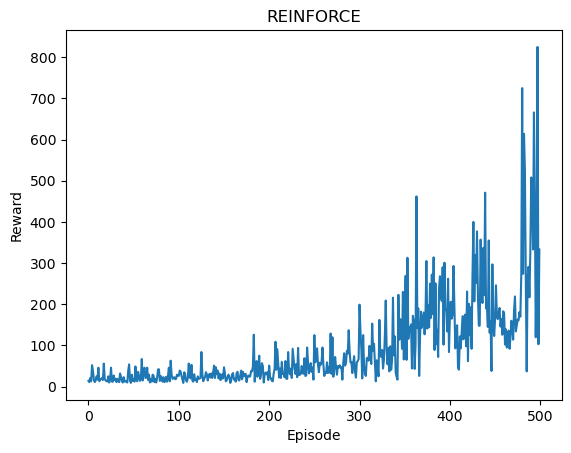

In [15]:
# Implementation of REINFORCE for the Cartpole environment with 64 nodes in hidden layer

ENV="CartPole-v1"

N_EPISODES=500

# set the env
env=gym.make(ENV) # env to import
env.reset() # reset to env

Agent = REINFORCE(env)

Agent.train(N_EPISODES)

#plot the rewards
import matplotlib.pyplot as plt
plt.plot(Agent.total_rewards)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('REINFORCE')
plt.show()

# save the model
Agent.save_model('saved_models\REINFORCE.h5')


In [4]:
# Hyperparametertuning with Bayesian Optimization for policy gradient

class REINFORCE_tuning(REINFORCE):
  def __init__(self, env, alpha, gamma, learning_rate, nodes):
    super().__init__(env)
    self.alpha = alpha
    self.gamma = gamma
    self.learning_rate = learning_rate
    self.nodes = nodes

def run_episodes(alpha, gamma, learning_rate, nodes):
        ENV="CartPole-v1"
        Train_EPISODES=200

        # set the env
        env=gym.make(ENV) # env to import
        env.reset() # reset to env

        James = REINFORCE_tuning(env, alpha=alpha, gamma=gamma, learning_rate=learning_rate, nodes=nodes)
        James.train(Train_EPISODES)
        James.test(50)
        env.close()
        test_rewards = James.total_test_rewards
        average_reward = np.average(test_rewards)
        return average_reward
import scipy.stats
from bayes_opt import BayesianOptimization

# https://github.com/bayesian-optimization/BayesianOptimization/tree/master
# Define the upper and lower boundaries of the hyperparameterspace
alphas = (0.2,0.9)
gammas = (0.5,0.9)
lrs = (0.001,0.3)
nodes = (48,96)

pbounds = {'alpha':alphas,'gamma':gammas,'learning_rate':lrs, 'nodes':nodes}

optimizer = BayesianOptimization(
    f=run_episodes,
    pbounds=pbounds,
    verbose=2,
    random_state=1
)

optimizer.maximize(
    init_points=10,  # Random exploration
    n_iter=50,       # Exploitation
)

|   iter    |  target   |   alpha   |   gamma   | learni... |   nodes   |
-------------------------------------------------------------------------
| 1         | 66.96     | 0.4919    | 0.7881    | 0.001034  | 62.51     |
| 2         | 40.04     | 0.3027    | 0.5369    | 0.05669   | 64.59     |
| 3         | 19.08     | 0.4777    | 0.7155    | 0.1263    | 80.89     |
| 4         | 192.5     | 0.3431    | 0.8512    | 0.009189  | 80.18     |
| 5         | 112.3     | 0.4921    | 0.7235    | 0.04298   | 57.51     |
| 6         | 264.9     | 0.7605    | 0.8873    | 0.09471   | 81.23     |
| 7         | 184.4     | 0.8135    | 0.8578    | 0.02643   | 49.87     |
| 8         | 182.3     | 0.3189    | 0.8513    | 0.03041   | 68.21     |
| 9         | 26.44     | 0.8705    | 0.7133    | 0.2079    | 63.14     |
| 10        | 237.5     | 0.6806    | 0.8339    | 0.006468  | 84.01     |
| 11        | 31.82     | 0.2054    | 0.5647    | 0.2131    | 84.71     |
| 12        | 64.58     | 0.5098    | 

           OPERATION           DATA DIMENSIONS   WEIGHTS(N)   WEIGHTS(%)

               Input   #####           4
               Dense   XXXXX -------------------      1280     1.0%
                relu   #####         256
               Dense   XXXXX -------------------    131584    98.3%
                relu   #####         512
               Dense   XXXXX -------------------      1026     0.8%
             softmax   #####           2


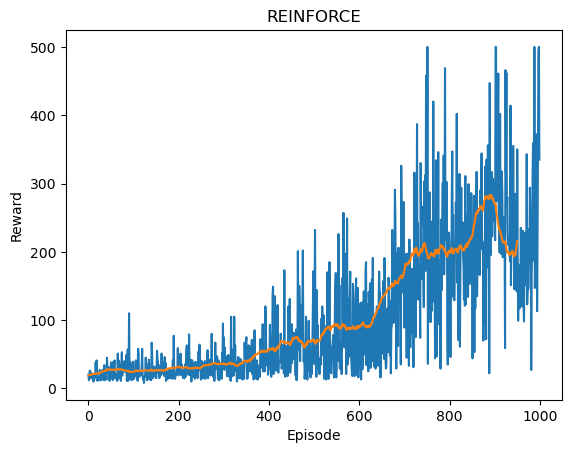

c:\Users\richa\.conda\envs\gym\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [18]:
# Implementation of REINFORCE for the Cartpole environment with Optimal Hyperparameters
# alpha = 0.4326
# gamma = 0.6939
# learning rate = 0.001
# nodes in the hidden layers = 87.4 => 88
# training episodes = 200

ENV="CartPole-v1"

N_EPISODES=1000

# set the env
env=gym.make(ENV) # env to import
env.reset() # reset to env

Agent = REINFORCE(env, alpha=0.4, gamma=0.7, learning_rate=0.0001, size_layer_1=256, size_layer_2=512, show_model=True)

Agent.train(N_EPISODES)

#plot the rewards
import matplotlib.pyplot as plt
average_rewards = moving_average(Agent.total_rewards, 50)
plt.plot(Agent.total_rewards)
plt.plot(average_rewards)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('REINFORCE')
plt.show()

# save the model
Agent.save_model('saved_models\REINFORCE-256-512.h5')

### Effect of Alpha
Alpha sets the rate at which the target values differ from the action probabilities and at which rate the policy network will be adjusted during training. High values of alpha will give a faster learning network but could lead to overshoots and possible oscillations in the policy which could give oscillating rewards (good - bad - good - ...).

### Hyperparameter tuning
The best result with an average score of 285.6 over 50 test episodes was given by the following hyperparameters:
alpha = 0.4326                      => Aggressive learning, would expect 0.0001
gamma = 0.6939                      => normal discount factor
learning rate = 0.1256              => To high, would expect 0.001
nodes in the hidden layers = 87.4   => I started with a small network. Bigger network needed because the compelxity of the environment was underrated.

### Comparrison to DQN
First of all the REINFORCE needs much more trainig episodes than the DQN. 
The resulting model is more consistent than DQN but still not perfect. The oscillations remain but with an higher average reward. *I think the aggressiveness of the training gives the oscillations. A lower alpha would have helped.*

### Exploration vs exploitation
During the first episodes the agent doesn't have enough successful samples to train on so it will explore more given the randomness of the weights in the NN during setup and the low variance action probability distribution. All actions are equally possible and it will take some time before the distinction shows up. Since the policy network is trained after every episode, it will take some time before a streak of good examples/episodes shows up. If the learning rate is taken small, the agent will keep on exploring untill the action probabilities give a clear distinction between good actions (high prob) and bad actions (low prob). When only the good actions have high probabilities, the agent will start exploiting.

## 2. Lunarlander environment

- Solve the OpenAI Gym Lunarlander environment with REINFORCE. 
- Plot the reward history (learning curve). For each episode plot the cumulative reward, or even better: plot average cumulative reward over a certain number of episodes (for example 50 episodes).
- Compare the results to the ones of Deep Q-learning. Check the speed of learning, consistency of the results, etc.

           OPERATION           DATA DIMENSIONS   WEIGHTS(N)   WEIGHTS(%)

               Input   #####           8
               Dense   XXXXX -------------------      2304     1.7%
                relu   #####         256
               Dense   XXXXX -------------------    131584    96.8%
                relu   #####         512
               Dense   XXXXX -------------------      2052     1.5%
             softmax   #####           4


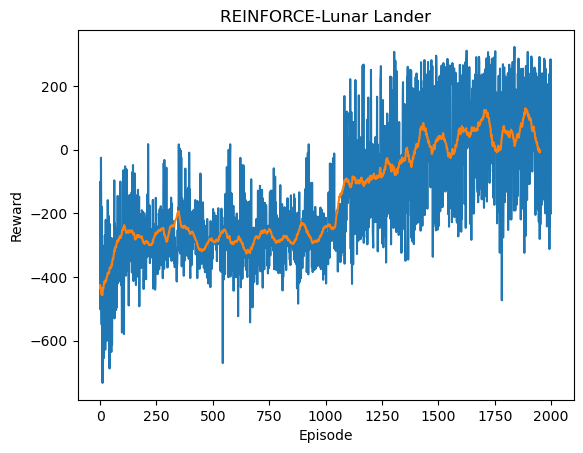

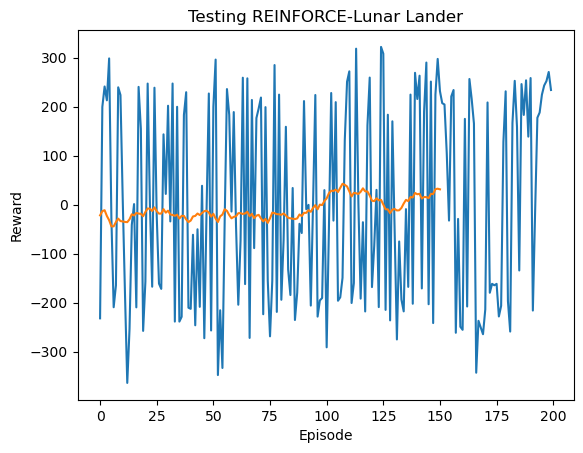

c:\Users\richa\.conda\envs\gym\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [20]:
# Implementation of REINFORCE for the Lunarlander environment 

# Implementation of REINFORCE for the Cartpole environment with Optimal Hyperparameters
# alpha = 0.4326
# gamma = 0.6939
# learning rate = 0.001
# nodes in the hidden layers = 87.4 => 88
# training episodes = 200

ENV="LunarLander-v2"

N_EPISODES=2000

# set the env
env=gym.make(ENV) # env to import
env.reset() # reset to env

Agent = REINFORCE(env, alpha=0.6, gamma=0.8, learning_rate=0.001, size_layer_1=256, size_layer_2=512, show_model=True)

Agent.train(N_EPISODES)
Agent.test(200)
#plot the rewards
import matplotlib.pyplot as plt
average_rewards = moving_average(Agent.total_rewards, 50)
plt.plot(Agent.total_rewards)
plt.plot(average_rewards)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('REINFORCE-Lunar Lander')
plt.show()

average_test_rewards = moving_average(Agent.total_test_rewards, 50)
plt.plot(Agent.total_test_rewards)
plt.plot(average_test_rewards)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Testing REINFORCE-Lunar Lander')
plt.show()
# save the model
Agent.save_model('saved_models\REINFORCE-LL-256-512.h5')

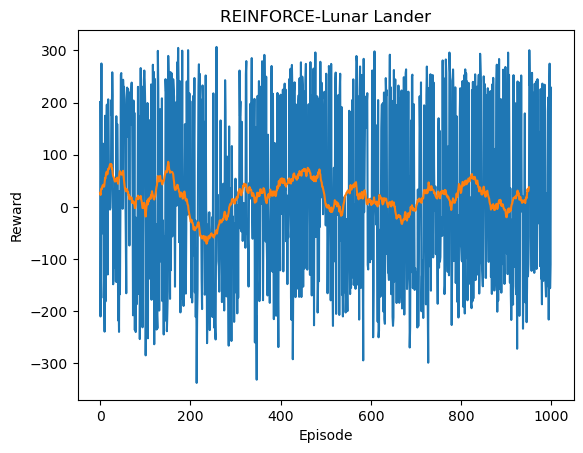

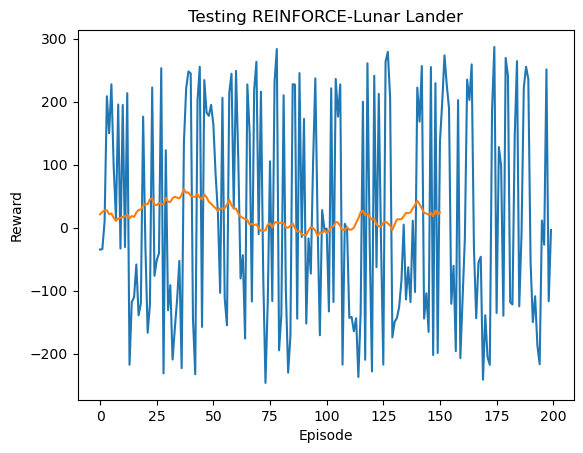

c:\Users\richa\.conda\envs\gym\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [27]:
# Next 1000 steps to see if we can improve the model
path = 'saved_models\REINFORCE-LL-256-512.h5'
ENV="LunarLander-v2"

N_EPISODES=1000

# set the env
env=gym.make(ENV) # env to import
env.reset() # reset to env

Agent = REINFORCE(env, path=path, alpha=0.6, gamma=0.8, show_model=True)

Agent.train(N_EPISODES)
Agent.test(200)
#plot the rewards
import matplotlib.pyplot as plt
average_rewards = moving_average(Agent.total_rewards, 50)
plt.plot(Agent.total_rewards)
plt.plot(average_rewards)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('REINFORCE-Lunar Lander')
plt.show()

average_test_rewards = moving_average(Agent.total_test_rewards, 50)
plt.plot(Agent.total_test_rewards)
plt.plot(average_test_rewards)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Testing REINFORCE-Lunar Lander')
plt.show()
# save the model
Agent.save_model('saved_models\REINFORCE-LL-256-512.h5')

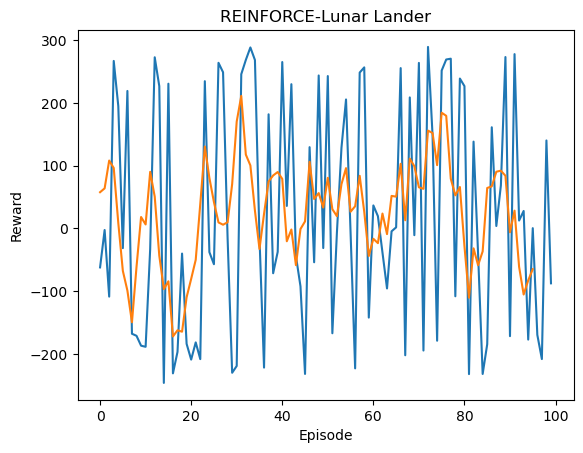

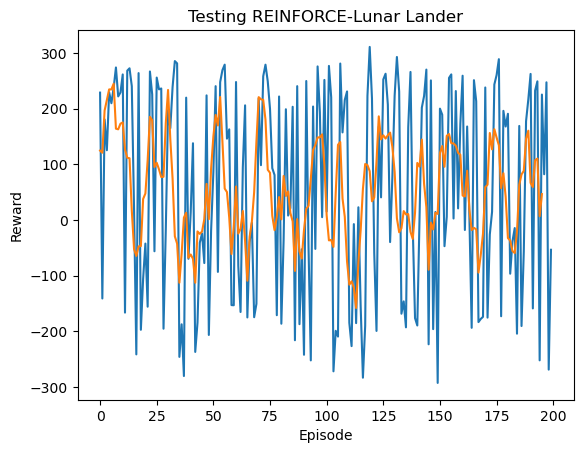

In [30]:
# Next 1000 steps to see if we can improve the model
path = 'saved_models\REINFORCE-LL-256-512.h5'
ENV="LunarLander-v2"

N_EPISODES=100

# set the env
env=gym.make(ENV) # env to import
env.reset() # reset to env

Agent = REINFORCE(env, path=path, alpha=0.01, gamma=0.6, show_model=True)

Agent.train(N_EPISODES)

#plot the rewards
import matplotlib.pyplot as plt
average_rewards = moving_average(Agent.total_rewards, 5)
plt.plot(Agent.total_rewards)
plt.plot(average_rewards)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('REINFORCE-Lunar Lander')
plt.show()

Agent.test(200)
average_test_rewards = moving_average(Agent.total_test_rewards, 5)
plt.plot(Agent.total_test_rewards)
plt.plot(average_test_rewards)
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Testing REINFORCE-Lunar Lander')
plt.show()
# save the model
Agent.save_model('saved_models\REINFORCE-LL-256-512.h5')

### REINFORCE vs DQN
With DQN I could not solve the environment, with REINFORCE a little more. 100 consecutive steps above 200 was not acchieved.
Training of the REINFORCE goes very tiresome. Only an increase in average reward was found after 1000 episodes. After that the training had no effect anymore.
This is strange because I would expect two effects: 1. periodic increase in average reward, 2. less variation in rewards.

